# TP2 - Clustering (Avec Réduction de Dimension)

Ce notebook charge les données Hi-Seq normalisées depuis `data/`. Il applique d'abord une réduction de dimension (PCA et UMAP) à 100 composantes, puis applique K-Means, DBSCAN et Spectral Clustering sur ces données réduites.

In [1]:
# --- Imports ---
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
import umap
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import time
import tracemalloc
import warnings

c:\Users\sebdr\anaconda3\envs\udes_sd_a25\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuration des Chemins ---

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED_PATH = PROJECT_ROOT / "data"
PROJECT_FCT = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_FCT))

print(f"Chemin du projet racine : {PROJECT_ROOT}")
print(f"Chargement des données depuis : {DATA_PROCESSED_PATH}")

Chemin du projet racine : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git
Chargement des données depuis : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git\data


In [3]:
# --- Chargement des modules locaux ---

try:
    from utils import evaluate_clustering, plot_clusters
    from preprocess import reduce_dimension_for_viz, reduce_dimension_for_clustering
    print("Modules locaux 'utils' et 'preprocess' chargés avec succès.")
except ImportError:
    print("Attention: Les fichiers utils.py ou preprocess.py n'ont pas été trouvés dans /src.")
    print("Définition de fonctions de remplacement (placeholders).")
    
warnings.filterwarnings('ignore')

Modules locaux 'utils' et 'preprocess' chargés avec succès.


In [4]:
# --- Chargement des données ---
print("Chargement des données Hi-Seq normalisées...")
try:
    X_scaled = np.load(DATA_PROCESSED_PATH / 'hiseq_X_scaled.npy')
    y_hiseq = pd.read_csv(DATA_PROCESSED_PATH / 'hiseq_y_labels.csv', index_col=0).iloc[:, 0]
    print(f"Données chargées. Forme de X_scaled: {X_scaled.shape}")
except FileNotFoundError:
    print(f"ERREUR: Fichiers non trouvés dans {DATA_PROCESSED_PATH}")
    print("Veuillez d'abord exécuter le notebook 'PreparationData.ipynb'.")

Chargement des données Hi-Seq normalisées...
Données chargées. Forme de X_scaled: (801, 20531)


# 1. Réduction de Dimension (100 composantes)
 Nous allons réduire les 20k+ dimensions à 100 en utilisant deux méthodes.

In [5]:
# --- PCA (100) ---
X_pca_100 = reduce_dimension_for_clustering(X_scaled, method='PCA', n_components=100)

Début de la réduction de dimension avec PCA à 100 composantes...
Réduction PCA terminée. Nouvelle forme : (801, 100)


In [ ]:
# --- UMAP (100) ---
X_umap_100 = reduce_dimension_for_clustering(X_scaled, method='UMAP', n_components=100)

Début de la réduction de dimension avec UMAP à 100 composantes...
Réduction UMAP terminée. Nouvelle forme : (801, 100)
Forme après UMAP: (801, 100)


# 2. Clustering sur Données Réduites (PCA)
Nous appliquons maintenant les algorithmes de clustering sur les données réduites par PCA.

Exécution de K-Means (PCA)...
{'Silhouette': 0.20495059496012094, 'Homogeneity': 0.8661659733680518, 'Completeness': 0.8518548889087146, 'V-Measure': 0.8589508255937418, 'ARI': 0.7999572043677019}
Réduction de dimension pour la visualisation avec umap...


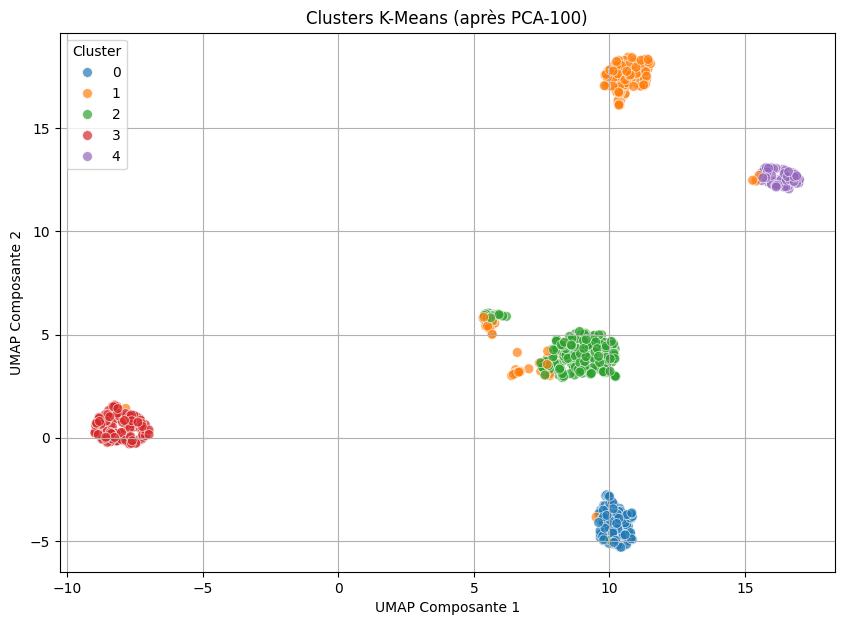

In [7]:
# --- K-Means (PCA) ---
print("Exécution de K-Means (PCA)...")
kmeans_pca = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca_100)
results_kmeans_pca = evaluate_clustering(X_pca_100, labels_kmeans_pca, y_hiseq)
print(results_kmeans_pca)
plot_clusters(X_pca_100, labels_kmeans_pca, title="Clusters K-Means (après PCA-100)")

In [8]:
# --- DBSCAN (PCA) ---
print("Calcul de EPS pour DBSCAN (PCA)...")
neighbors_pca = NearestNeighbors(n_neighbors=5)
neighbors_fit_pca = neighbors_pca.fit(X_pca_100)
distances_pca, _ = neighbors_fit_pca.kneighbors(X_pca_100)
distances_pca = np.sort(distances_pca, axis=0)[:, 4]
kneedle_pca = KneeLocator(range(len(distances_pca)), distances_pca, curve='convex', direction='increasing')
EPS_PCA_OPTIMAL = kneedle_pca.elbow_y if kneedle_pca.elbow_y else 126.0 # Fallback
print(f"EPS Optimal (PCA) trouvé: {EPS_PCA_OPTIMAL}")

Calcul de EPS pour DBSCAN (PCA)...
EPS Optimal (PCA) trouvé: 126.53904060021102



Exécution de DBSCAN (PCA)...
{'Silhouette': nan, 'Homogeneity': 0.0, 'Completeness': 1.0, 'V-Measure': 0.0, 'ARI': 0.0, 'Noise_Percentage': 5.368289637952559}
Réduction de dimension pour la visualisation avec umap...


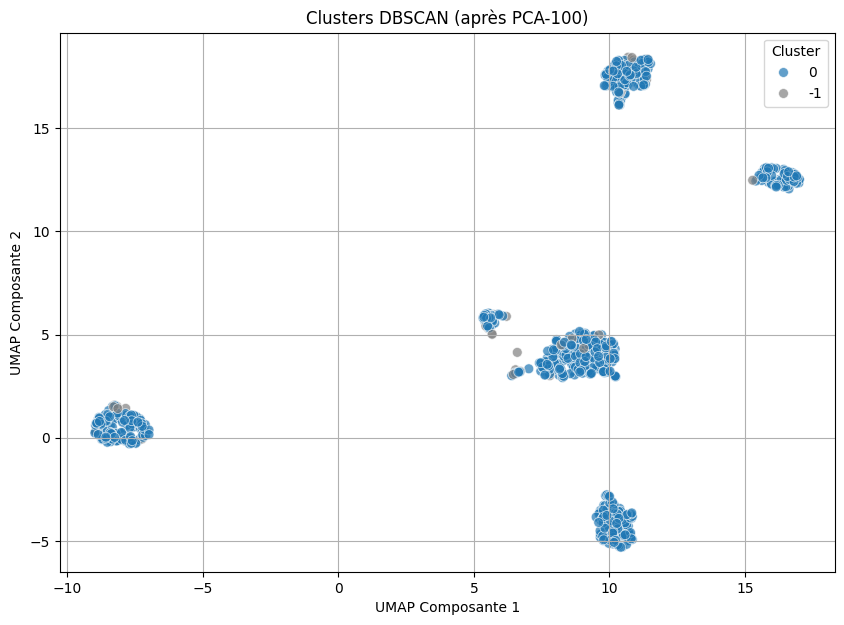

In [9]:
print("\nExécution de DBSCAN (PCA)...")
dbscan_pca = DBSCAN(eps=EPS_PCA_OPTIMAL, min_samples=5)
labels_dbscan_pca = dbscan_pca.fit_predict(X_pca_100)
results_dbscan_pca = evaluate_clustering(X_pca_100, labels_dbscan_pca, y_hiseq, allow_noise=True)
print(results_dbscan_pca)
plot_clusters(X_pca_100, labels_dbscan_pca, title="Clusters DBSCAN (après PCA-100)")

Exécution de Spectral Clustering (PCA)...
{'Silhouette': -0.07401581567436762, 'Homogeneity': 0.004904285780407865, 'Completeness': 0.010567042378870902, 'V-Measure': 0.006699333780026259, 'ARI': 0.003306452428438863}
Réduction de dimension pour la visualisation avec umap...


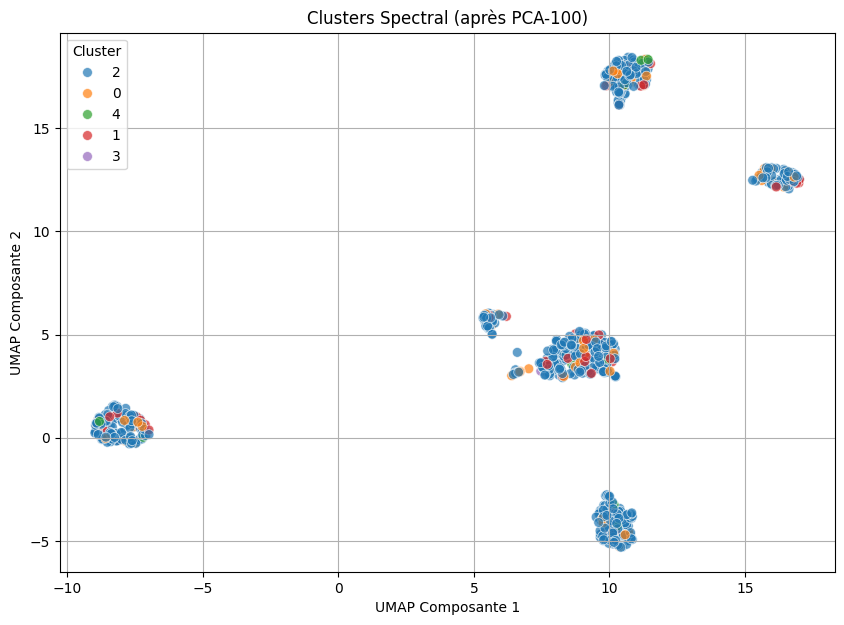

In [10]:
# --- Spectral Clustering (PCA) ---
print("Exécution de Spectral Clustering (PCA)...")
spectral_pca = SpectralClustering(n_clusters=5, assign_labels='kmeans', random_state=42)
labels_spectral_pca = spectral_pca.fit_predict(X_pca_100)
results_spectral_pca = evaluate_clustering(X_pca_100, labels_spectral_pca, y_hiseq)
print(results_spectral_pca)
plot_clusters(X_pca_100, labels_spectral_pca, title="Clusters Spectral (après PCA-100)")

# 3. Clustering sur Données Réduites (UMAP)

Nous répétons les algorithmes sur les données réduites par UMAP.

Exécution de K-Means (UMAP)...
{'Silhouette': 0.8964177966117859, 'Homogeneity': 0.9900670697034507, 'Completeness': 0.9913203884404855, 'V-Measure': 0.990693332681083, 'ARI': 0.9925379262715904}
Réduction de dimension pour la visualisation avec umap...


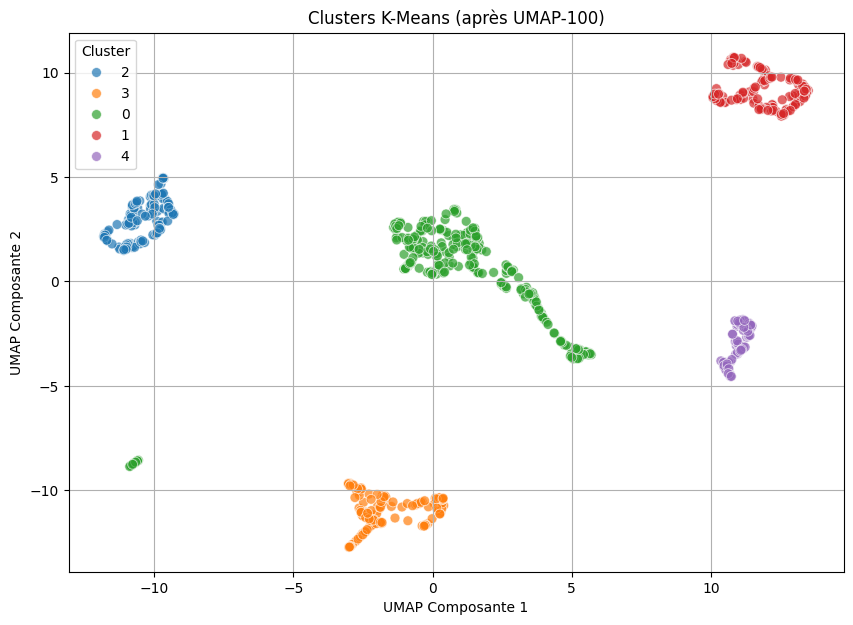

In [11]:
# --- K-Means (UMAP) ---
print("Exécution de K-Means (UMAP)...")
kmeans_umap = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_kmeans_umap = kmeans_umap.fit_predict(X_umap_100)
results_kmeans_umap = evaluate_clustering(X_umap_100, labels_kmeans_umap, y_hiseq)
print(results_kmeans_umap)
plot_clusters(X_umap_100, labels_kmeans_umap, title="Clusters K-Means (après UMAP-100)")

In [12]:
# --- DBSCAN (UMAP) ---
print("Calcul de EPS pour DBSCAN (UMAP)...")
neighbors_umap = NearestNeighbors(n_neighbors=5)
neighbors_fit_umap = neighbors_umap.fit(X_umap_100)
distances_umap, _ = neighbors_fit_umap.kneighbors(X_umap_100)
distances_umap = np.sort(distances_umap, axis=0)[:, 4]
kneedle_umap = KneeLocator(range(len(distances_umap)), distances_umap, curve='convex', direction='increasing')
EPS_UMAP_OPTIMAL = kneedle_umap.elbow_y if kneedle_umap.elbow_y else 0.42 # Fallback
print(f"EPS Optimal (UMAP) trouvé: {EPS_UMAP_OPTIMAL}")

Calcul de EPS pour DBSCAN (UMAP)...
EPS Optimal (UMAP) trouvé: 0.4881645143032074



Exécution de DBSCAN (UMAP)...
{'Silhouette': 0.8965345025062561, 'Homogeneity': 0.9944527736804537, 'Completeness': 0.9950820561026245, 'V-Measure': 0.9947673153717014, 'ARI': 0.9962544154590319, 'Noise_Percentage': 0.24968789013732834}
Réduction de dimension pour la visualisation avec umap...


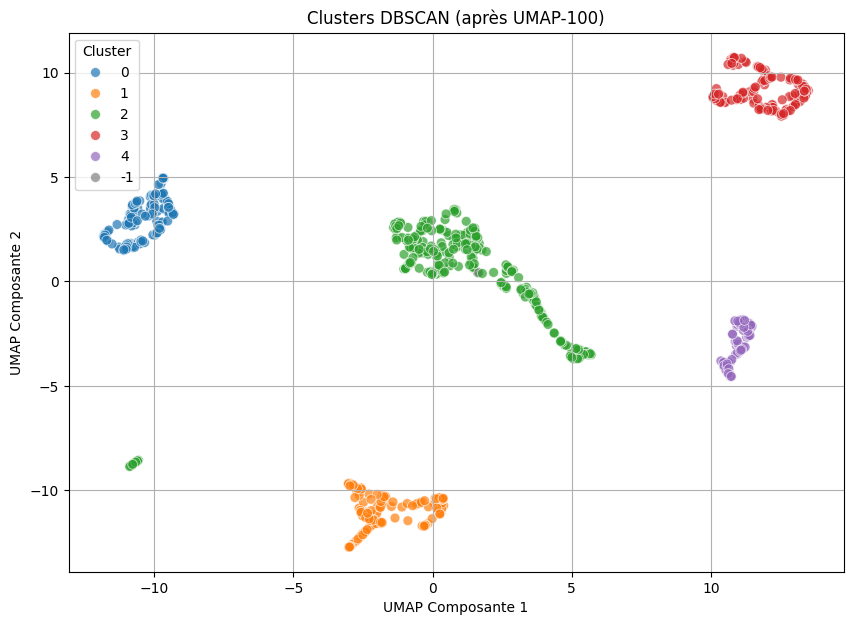

In [13]:
print("\nExécution de DBSCAN (UMAP)...")
dbscan_umap = DBSCAN(eps=EPS_UMAP_OPTIMAL, min_samples=5)
labels_dbscan_umap = dbscan_umap.fit_predict(X_umap_100)
results_dbscan_umap = evaluate_clustering(X_umap_100, labels_dbscan_umap, y_hiseq, allow_noise=True)
print(results_dbscan_umap)
plot_clusters(X_umap_100, labels_dbscan_umap, title="Clusters DBSCAN (après UMAP-100)")

Exécution de Spectral Clustering (UMAP)...
{'Silhouette': 0.32011884450912476, 'Homogeneity': 0.7788873018341572, 'Completeness': 0.8818104516047655, 'V-Measure': 0.8271595020313922, 'ARI': 0.642697478060984}
Réduction de dimension pour la visualisation avec umap...


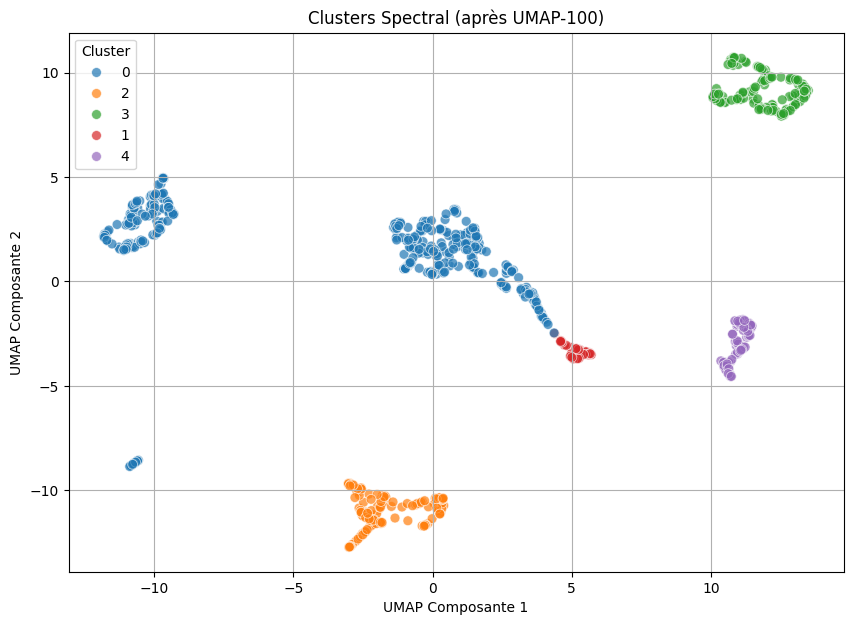

In [14]:
# --- Spectral Clustering (UMAP) ---
print("Exécution de Spectral Clustering (UMAP)...")
spectral_umap = SpectralClustering(n_clusters=5, assign_labels='kmeans', random_state=42)
labels_spectral_umap = spectral_umap.fit_predict(X_umap_100)
results_spectral_umap = evaluate_clustering(X_umap_100, labels_spectral_umap, y_hiseq)
print(results_spectral_umap)
plot_clusters(X_umap_100, labels_spectral_umap, title="Clusters Spectral (après UMAP-100)")

# 4. Comparaison (Données Réduites)

In [15]:
# Décommentez pour afficher le tableau de comparaison
results_list = [
     {**results_kmeans_pca, 'Jeu': 'PCA', 'Algo': 'KMeans'},
     {**results_dbscan_pca, 'Jeu': 'PCA', 'Algo': 'DBSCAN'},
     {**results_spectral_pca, 'Jeu': 'PCA', 'Algo': 'Spectral'},
     {**results_kmeans_umap, 'Jeu': 'UMAP', 'Algo': 'KMeans'},
     {**results_dbscan_umap, 'Jeu': 'UMAP', 'Algo': 'DBSCAN'},
     {**results_spectral_umap, 'Jeu': 'UMAP', 'Algo': 'Spectral'},
]

df_rd_results = pd.DataFrame(results_list).set_index(['Jeu', 'Algo'])
print(df_rd_results.to_markdown(floatfmt=".4f"))

|                      |   Silhouette |   Homogeneity |   Completeness |   V-Measure |    ARI |   Noise_Percentage |
|:---------------------|-------------:|--------------:|---------------:|------------:|-------:|-------------------:|
| ('PCA', 'KMeans')    |       0.2050 |        0.8662 |         0.8519 |      0.8590 | 0.8000 |           nan      |
| ('PCA', 'DBSCAN')    |     nan      |        0.0000 |         1.0000 |      0.0000 | 0.0000 |             5.3683 |
| ('PCA', 'Spectral')  |      -0.0740 |        0.0049 |         0.0106 |      0.0067 | 0.0033 |           nan      |
| ('UMAP', 'KMeans')   |       0.8964 |        0.9901 |         0.9913 |      0.9907 | 0.9925 |           nan      |
| ('UMAP', 'DBSCAN')   |       0.8965 |        0.9945 |         0.9951 |      0.9948 | 0.9963 |             0.2497 |
| ('UMAP', 'Spectral') |       0.3201 |        0.7789 |         0.8818 |      0.8272 | 0.6427 |           nan      |
